# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Лабораторная работа </center>
# <center> Алгоритм Гриффина-Лима </center>

In [503]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import IPython
import IPython.display as ipd
import copy
from scipy import signal

Функция отрисовки аудио сигнала

In [504]:
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveshow(wav, sr=sr)
    plt.show()

## Предобработка

### Загрузим исходный сигнал

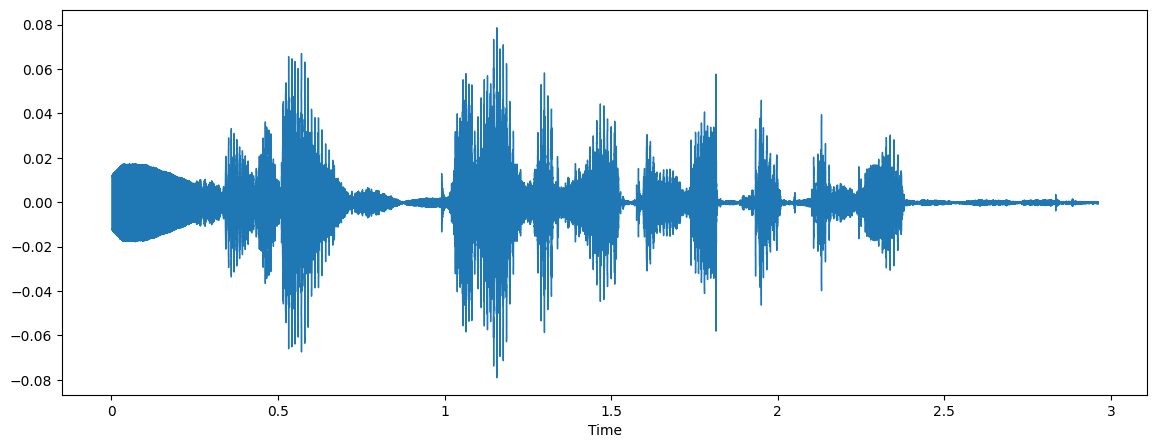

In [505]:
wav, sr = librosa.load("22050.wav", sr=None)
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

### Определим функцию для предобработки аудиоданных

In [506]:
def preprocess(wav, trim=False, filter=None):
  x = wav
  if trim:
    # Обрезаем тишину по краям
    x, _ = librosa.effects.trim(x)
  if filter:
    # Применяем фильтр усиления высоких частот
    x = np.append(x[0], x[1] - filter * x[:-1])
  return x

In [507]:
x = preprocess(wav, trim=True, filter=0.97)

## Вычисление спектрограммы

### Вычисляем дискретное преобразование Фурье для всех кадров сигнала

In [508]:
N = 2048 # — размерность ДПФ
h = 512  # — величина сдвига
Y = librosa.stft(x, n_fft=N, hop_length=h)

### Вычисляем спектрограмму

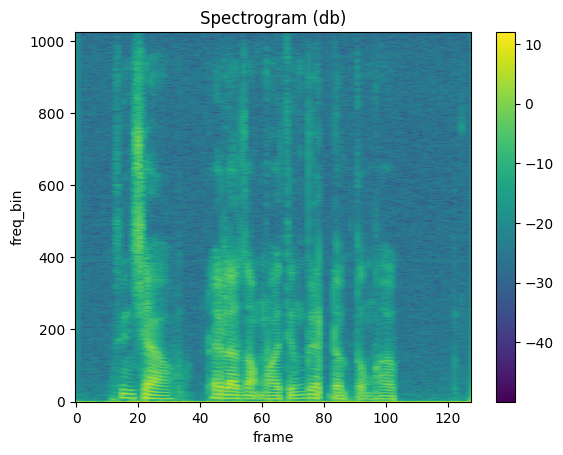

In [509]:
D = np.abs(Y)

fig, axs = plt.subplots(1, 1)
axs.set_title('Spectrogram (db)')
axs.set_ylabel('freq_bin')
axs.set_xlabel('frame')
im = axs.imshow(librosa.power_to_db(D), origin='lower', aspect='auto')
fig.colorbar(im, ax=axs)
plt.show(block=False)

### Реализация алгоритма Гриффина-Лима

In [510]:
def griffin_lim(spec, N, h, imax):
    spec_copy = copy.deepcopy(spec)

    for i in range(imax):
        X_t = librosa.istft(spec_copy, hop_length=h)

        E = librosa.stft(X_t, n_fft=N, hop_length=h)

        phase = E / np.maximum(1e-8, np.abs(E))

        spec_copy = spec * phase

    X_t = librosa.istft(spec_copy, hop_length=h)

    X_out = np.real(X_t)
    return X_out

In [511]:
X_out = griffin_lim(D, N, h, 1024)

## Постобработка

### Коррекция 𝑋, используя De-Emphasis

In [512]:
X_out = signal.lfilter([1], [1, -0.97], X_out)

### Воспроизведение синтезированного звука

In [513]:
ipd.Audio(X_out, rate=sr)

## Исследовать зависимость качества преобразования от следующих параметров:
- использования фильтра усиления высоких частот и его параметра 𝛼;
- размерности дискретного преобразования Фурье: 𝑁 = 512, 1024, 2048, 4096;
- величины сдвига ℎ = 𝑁/4, 𝑁/2, 𝑁;
- числа итераций алгоритма Гриффина-Лима 𝑖max = 16, 32, 64, 128, 256.

Построить общую функцию для восстановления записанного речевого сигнала по его спектрограмме алгоритмом Гриффина-Лима

In [514]:
def reconstruct_record(wav, alpha=None, N=2048, h=512, imax=128):
  x = preprocess(wav, trim=True, filter=alpha)
  Y = librosa.stft(x, n_fft=N, hop_length=h)
  D = np.abs(Y)
  X_out = griffin_lim(D, N, h, imax)
  if alpha:
    X_out = signal.lfilter([1], [1, -alpha], X_out)
  return X_out

### Зависимость качества преобразования от использования фильтра усиления высоких частот и его параметра 𝛼

In [515]:
ipd.Audio(reconstruct_record(wav, alpha=None), rate=sr)

In [516]:
ipd.Audio(reconstruct_record(wav, alpha=0.5), rate=sr)

In [517]:
ipd.Audio(reconstruct_record(wav, alpha=0.97), rate=sr)

=> При неприменении фильтра звук становится ближе к исходному звуку, при применении фильтра значительно убирается шум, чем больше параметр альфа, тем глубже получаемый звук

### Зависимость качества преобразования от размерности дискретного преобразования Фурье

In [518]:
for i in [ 512, 1024, 2048, 4096]:
    print("N =", i)
    IPython.display.display(ipd.Audio(reconstruct_record(wav, N=i, h=i//4), rate=sr))

N = 512


N = 1024


N = 2048


N = 4096


=> Звук звучит более дискретно, когда N мало, и более смешанный, когда N увеличивается.

### Зависимость качества преобразования от величины сдвига ℎ

In [519]:
for i in [1/4, 1/2, 1]:
    print("h =", 2048*i)
    IPython.display.display(ipd.Audio(reconstruct_record(wav, N=2048, h=int(2048*i)), rate=sr))

h = 512.0


h = 1024.0


h = 2048


=> Качество звука лучше всего достигается при h=N/4 и ухудшается с увеличением h, при h=N становится невозможно разобрать человеческую речь.

### Зависимость качества преобразования от числа итераций алгоритма Гриффина-Лима 𝑖max

In [520]:
for i in [16, 32, 64,128,256]:
    print("imax =", i)
    IPython.display.display(ipd.Audio(reconstruct_record(wav, alpha=None, imax=i), rate=sr))

imax = 16


imax = 32


imax = 64


imax = 128


imax = 256


=> Качество звука увеличивается с увеличением imax